# Tutorial 03: Counterfactual analysi & Rewrite rules

For scalable counterfactual analysis, Errudite uses rules to rewrite all relevant instances within a group – similar to search and replace but with the flexibility and power of the Errudite DSL. 

Just like `DatasetReader`, `Predictor` and `PrimFunc`, `Rewrite` allows extension through `register`. There are two large types of rewrite rules: defaults (see the documentation), and those implemented in the syntax of `rewrite(target, from -> to)`: 

> Target indicates the part of the instance that should be rewritten by replacing from with to. Depending on whether or not you want to use linguistic features.

We will introduce the latter here.

### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

def import_sys():
    import sys
    sys.path.append('..')
import_sys()

import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)  # pylint: disable=invalid-name

import errudite
print(errudite)

<module 'errudite' from '../errudite/__init__.py'>


In [2]:
# set the dataset reader
from errudite.io import DatasetReader

cache_folder_path = "./data/snli_tutorial_caches/"
reader = DatasetReader.by_name("snli")(
    cache_folder_path=cache_folder_path)
instances = reader.load_preprocessed()

INFO:errudite.utils.file_utils:Errudite cache folder selected: ./data/snli_tutorial_caches/
INFO:errudite.io.dataset_reader:Loaded 100 objects to ./data/snli_tutorial_caches/instances.pkl.
INFO:errudite.io.dataset_reader:Loaded 100 objects to ./data/snli_tutorial_caches/evaluations/decompose_att.pkl.


## Create the Pattern Replacing Rule

As mentioned before, a typical customized rewrite rule  rewrites the `target_cmd` part of an instance by replacing `from_cmd` with `to_cmd`. The name/rid of the rule is: `{from_cmd} -> {to_cmd}` ([documentation](https://errudite.readthedocs.io/en/latest/api/errudite.rewrites.defines.html)).

Both `from_cmd` and `to_cmd` can include linguistic annotations, in ALL CAPS. For example, to create a rule that replaces all the cardinal numbers before a NOUN to "one" you can input `from_cmd="CARDINAL NOUN VERB"`, and `to_cmd="one NOUN VERB"`.

In [3]:
from errudite.rewrites import Rewrite
rewrite = Rewrite.create_with_cmd(
    from_cmd='CARDINAL NOUN VERB', 
    to_cmd='one NOUN VERB', 
    target_cmd='premise'
)

INFO:errudite.build_blocks.wrapper:Parsed: premise


<class 'errudite.rewrites.replace_pattern.ReplacePattern'>


In [5]:
rewrite.pattern

PatternMeta(before=({'ENT_TYPE': 'CARDINAL', 'OP': '+'}, {'POS': 'NOUN'}, {'POS': 'VERB'}), after=({'LOWER': 'one'}, {'POS': 'NOUN'}, {'POS': 'VERB'}))

### Run the rewrite and save the new instance

Once a rewrite is created, you could apply the rewrite to all instances at once, and formalize the rewritten instances in a way similar to the preprocessing steps.

In [ ]:
# ---------
# load a predictor
from errudite.predictors import Predictor
model_online_path = "https://s3-us-west-2.amazonaws.com/allennlp/models/decomposable-attention-elmo-2018.02.19.tar.gz"
predictor = Predictor.by_name("nli_decompose_att")(
    name='decompose_att', 
    description='Pretrained model from Allennlp, for the decomposable attention model',
    model_online_path=model_online_path)

In [10]:

from errudite.targets.instance import Instance
from errudite.targets.target import Target

for instance in Instance.instance_hash.values():
    """
    This function returns a named tuple, with rid and the 
    rewritten text of the instance intended target. 
    If the instance cannot be rewritten, return None.
    """
    rewritten_output = rewrite.rewrite_one_instance(instance)
    if not rewritten_output:
        continue
    entries = {}
    # compute the vid automatically
    vid = len(Instance.qid_hash[instance.qid])
    # init the instance 
    rewritten_instance = Instance(
        qid=instance.qid, vid=vid, rid=rewrite.rid)
    for e in instance.entries:
        if e in rewrite.target_cmd:
            # automatically create a new Target for the 
            # rewritten part.
            entry = Target(
                qid=instance.qid, 
                text=rewritten_output.text, 
                vid=vid, 
                metas=instance.get_entry(e).metas)
        else:
            # Otherwise, use the original target
            entry = instance.get_entry(e)
        # save all the entries
        rewritten_instance.set_entries(**{e: entry})
    # run the prediction
    prediction = Predictor.by_name("nli_task_class").model_predict(
        predictor, 
        rewritten_instance.get_entry('premise'), 
        rewritten_instance.get_entry('hypothesis'), 
        rewritten_instance.get_entry('groundtruth'))
    # save the prediction
    rewritten_instance.set_entries(prediction=prediction)
    # set the rewritten key into the rewrite
    rewrite.add_instance(rewritten_instance.key())
    # save into the Instance hashes
    Instance.save(rewritten_instance)

Take a look at one rewritten instance:

In [11]:
ie = list(Instance.instance_hash_rewritten.values())[0]
ie.show_instance()

[Instance] [InstanceKey(qid='4705552913.jpg#2r1n', vid=1)]
[hypothesis]	The sisters are hugging goodbye while holding to go packages after just eating lunch.
[premise]	One women are embracing while holding to go packages.
[groundtruth]	neutral	groundtruth	{}
[predictions]	neutral	decompose_att	{'accuracy': 1.0, 'confidence': 0.9986408352851868}
[prediction]	neutral	decompose_att	{'accuracy': 1.0, 'confidence': 0.9981850981712341}



#### Visualize rewritten instance changing status:

The visualization for a rewrite rule is one-bar histogram that displays the count of instances rewritten, and the proportion of "flip_to_correct", "flip_to_incorrect", "unflip". Because of the flipping proportion, this historgram is different for each different model. 

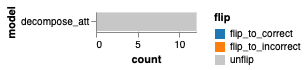

In [12]:
rewrite.visualize_models(models=["decompose_att"])

We could also print the instance correctness for the given filtering instance in numbers:

In [13]:
from errudite.rewrites import Rewrite
Rewrite.eval_stats(rewrite,qids=None)

{'counts': {'rewritten': 12,
  'prediction_changed': 0,
  'flips': {'flip_to_correct': 0, 'flip_to_incorrect': 0, 'unflip': 12}},
 'stats': {'coverage': 0.12, 'changed_coverage': 0.0, 'changed_rate': 0.0}}

## Rewrites defined with customized functions

Similar to attributes and groups, rewrites can be defined with functions ([documentation]()): 

In [16]:
rewrite_no_change = Rewrite.create_with_func(
    rewrite_func=lambda instance: "You know what? " + instance.premise.doc.text,
    target_cmd='premise'
)

INFO:errudite.build_blocks.wrapper:Parsed: premise


# Save & reload

The saving and reloading of rewrite rules are similar to those of attributes or groups.

In [ ]:
Rewrite.export_to_file (file_name="save_rewrite.json")

In [12]:
Rewrite.import_from_file('save_rewrite.json')

INFO:errudite.build_blocks.wrapper:Parsed: premise


{'CARDINAL NOUN VERB -> one NOUN VERB': [ReplacePattern] CARDINAL NOUN VERB -> one NOUN VERB}